In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/preprocessed_data_a.csv')
data.head()

,sex,age,OSA,insomnia,"PLMD, RLS",parasomnia,circadian rhythm sleep-wake disorder,"Narcolepsy, EDS, Hypersomnia",Catathrenia,control,...,Lowest SaO2 (%),ODI,90%ODI,EtCO2 (>50mmHg),Total LMI =PLMI(/h),Total LM Arousal#,Total LM AI(/h),PLM Arousal#,PLM AI(/h),MAI(/h)
0,1,55,1,0,0,0,0,0,0,0,...,88.0,0.0,0.0,0.0,3.2,2.0,0.3,0.0,0.0,0.3
1,0,48,1,0,0,0,0,0,0,0,...,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,55,1,0,0,0,0,0,0,0,...,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,50,1,0,0,0,0,0,0,0,...,83.0,0.0,0.0,0.0,46.8,0.0,0.0,0.0,0.0,0.0
4,0,57,1,0,0,0,0,0,0,0,...,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [4]:
def cm_labels(cm):
    label_names = ['TN', 'FP', 'FN', 'TP']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{ln}\n{c}\n{p}" for ln, c, p in zip(label_names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    return labels

In [5]:
def eval_metrics(y_test, title='Confusion Matrix', pred=None, pred_proba=None, multilabel=False):
    target_names = list(y_test.columns)    
    if multilabel:
        for i, y in enumerate(y_test.columns):
            accuracy = accuracy_score(y_test[y], pred[:, i])
            print(f'{y} accuracy: {accuracy}')
        total_accuracy = accuracy_score(y_test, pred)
        print(f'total accuracy: {total_accuracy}')

        cms = multilabel_confusion_matrix(y_test, y_pred)
        for i, cm in enumerate(cms):
            fig, ax = plt.subplots()
            labels = cm_labels(cm)
            sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax).set(title=f'{title} - {target_names[i]}')
    else:
        accuracy = accuracy_score(y_test, pred)
        print(f'accuracy: {accuracy}')
        
        cm = confusion_matrix(y_test, pred)
        labels = cm_labels(cm)
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax).set(title=title)
    
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    plt.show()

In [6]:
def eval_metrics_np(y_test, target_names=[], title='Confusion Matrix', pred=None, pred_proba=None):  
    for i in range(len(target_names)):
        accuracy = accuracy_score(y_test[:, i], pred[:, i])
        print(f'{target_names[i]} accuracy: {accuracy}')
    total_accuracy = accuracy_score(y_test, pred)
    print(f'total accuracy: {total_accuracy}')

    cms = multilabel_confusion_matrix(y_test, y_pred)
    for i, cm in enumerate(cms):
        fig, ax = plt.subplots()
        labels = cm_labels(cm)
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax).set(title=f'{title} - {target_names[i]}')

    print(classification_report(y_test, y_pred, target_names=target_names))
    
    plt.show()

In [7]:
target = data.iloc[:, 2:10]
features = data.drop(data.iloc[:, 2:10], axis=1)
target.head()

,OSA,insomnia,"PLMD, RLS",parasomnia,circadian rhythm sleep-wake disorder,"Narcolepsy, EDS, Hypersomnia",Catathrenia,control
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0


In [8]:
target.sum(axis=0)

OSA                                     3901
insomnia                                 482
PLMD, RLS                                598
parasomnia                               212
circadian rhythm sleep-wake disorder      94
Narcolepsy, EDS, Hypersomnia             129
Catathrenia                                7
control                                  379
dtype: int64

In [9]:
target.shape

(5161, 8)

### MLSMOTE
https://doi.org/10.1016/j.knosys.2015.07.019

In [10]:
from sklearn.neighbors import NearestNeighbors
import random

In [75]:
# ref: https://github.com/gnsrivastava/ec_class/blob/690433a6d296da6658aca4e4b22c4f08d5c1501a/mlsmote.py

def get_tail_label(df, q):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    #print(columns)
    n = len(columns)
    #print(n)
    irpl = np.zeros(n)  # Imbalance ratio per label: irpl
    #print(irpl)
    for column in range(n):
#         print(df[columns[column]].value_counts()[1])   # number of 1 in a label    df[columns[column]].value_counts() => output: class 0: 900, class 1: 100
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
#     print(irpl)
    if q < 0:
        mir = np.average(irpl)  # Mean Imbalance ratio: mir
    else:
        mir = np.quantile(irpl, q)
    print(mir)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            #print(columns[i])
            tail_label.append(columns[i])
#     print(tail_label)
    return tail_label

def get_index(df, q):
    """
    give the index of all tail_label rows
    args
    df: pandas.DataFrame, target label df from which index for tail label has to identified

    return
    index: list, a list containing index number of all the tail label
    """
    tail_labels = get_tail_label(df, q)
    print(tail_labels)
    index = set()
    for tail_label in tail_labels:
        #print(df[df[tail_label] == 1].index)   # gives indices of each row with tail_label =1
        sub_index = set(df[df[tail_label] == 1].index)
        #print(sub_index)
        index = index.union(sub_index)
        #print(index)
    return list(index)


def get_minority_instace(X, y, q=-1):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y, q)
    X_sub = X[X.index.isin(index)].reset_index(drop=True)
    #print(X[X.index.isin(index)].reset_index(drop=True)) # reset_index() will convert index to column0, drop = True will remove the old index as column0
    y_sub = y[y.index.isin(index)].reset_index(drop=True)
    return X_sub, y_sub


def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(
        n_neighbors=6, metric='euclidean', algorithm='kd_tree').fit(X)
    _, indices = nbs.kneighbors(X)
    #print(indices)
    return indices


def MLSMOTE(X, y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X) # Shape of indices2 = (33, 5) same as y_sub
    #print(indices2.shape)
    n = len(indices2) 
    #print(n)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)  # give number between 0 and 32
        neighbour = random.choice(indices2[reference, 1:])
#         print(indices2[reference,0:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis=0, skipna=True)
        target[i] = np.array([1 if val > 2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference, :] - X.loc[neighbour, :]
        new_X[i] = np.array(X.loc[reference, :] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target

In [82]:
X_sub, y_sub = get_minority_instace(features, target, q=-1)
X0, y0 = MLSMOTE(X_sub, y_sub, 100) # sample 수 100, mean이용('Catathrenia')

X_sub, y_sub = get_minority_instace(features, target, q=0.75)
X1, y1 = MLSMOTE(X_sub, y_sub, 100) # sample 수 100, quantile 0.75 ('circadian rhythm sleep-wake disorder', 'Catathrenia')

# concatenate
X_res = pd.DataFrame(np.concatenate((features, X0, X1), axis=0), columns=features.columns)
y_res = pd.DataFrame(np.concatenate((target, y0, y1), axis=0), columns=target.columns)

84.16707701449926
['Catathrenia']
33.05523255813954
['circadian rhythm sleep-wake disorder', 'Catathrenia']


In [83]:
y_res.describe()

,OSA,insomnia,"PLMD, RLS",parasomnia,circadian rhythm sleep-wake disorder,"Narcolepsy, EDS, Hypersomnia",Catathrenia,control
count,5469.000000,5469.000000,5469.000000,5469.000000,5469.000000,5469.000000,5469.000000,5469.000000
mean,0.721887,0.090510,0.110624,0.038764,0.052660,0.024319,0.022673,0.069300
std,0.448110,0.286937,0.313694,0.193050,0.223375,0.154051,0.148873,0.253986
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### MLSOL
ref: https://arxiv.org/pdf/1905.00609.pdf

# Logistic Regression

## MultiOutputClassifier

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [85]:
params_dict = {
    'estimator__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
}

logreg = LogisticRegression(max_iter=20000, random_state=42)

grid_logreg = GridSearchCV(MultiOutputClassifier(logreg, n_jobs=4), params_dict, cv=3, refit=True)
grid_logreg.fit(X_train, y_train)

print(grid_logreg.best_params_)
print(grid_logreg.best_score_)

{'estimator__C': 0.01}
0.6515151515151515


In [86]:
y_pred = grid_logreg.best_estimator_.predict(X_test)
y_pred_proba = grid_logreg.best_estimator_.predict_proba(X_test)

In [22]:
# logreg = LogisticRegression(C=0.01, max_iter=20000, random_state=42)
# multi_logreg = MultiOutputClassifier(logreg, n_jobs=4)
# multi_logreg.fit(X_train, y_train)

# y_pred = multi_logreg.predict(X_test)
# y_pred_proba = multi_logreg.predict_proba(X_test)

OSA accuracy: 0.9134673979280926
insomnia accuracy: 0.903107861060329
PLMD, RLS accuracy: 0.9073735527117611
parasomnia accuracy: 0.9658744667885436
circadian rhythm sleep-wake disorder accuracy: 0.9427178549664839
Narcolepsy, EDS, Hypersomnia accuracy: 0.9725776965265083
Catathrenia accuracy: 0.9859841560024375
control accuracy: 0.9335770871419866
total accuracy: 0.647775746496039
                                      precision    recall  f1-score   support

                                 OSA       0.94      0.94      0.94      1178
                            insomnia       0.47      0.22      0.30       155
                           PLMD, RLS       0.70      0.37      0.48       193
                          parasomnia       0.62      0.17      0.26        60
circadian rhythm sleep-wake disorder       0.54      0.16      0.24        96
        Narcolepsy, EDS, Hypersomnia       0.36      0.12      0.18        41
                         Catathrenia       0.56      0.54      0.55 

/Users/hannahan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


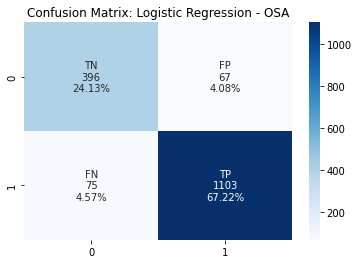

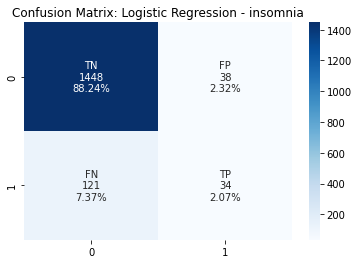

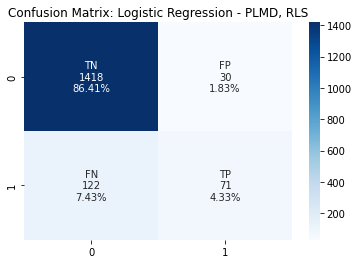

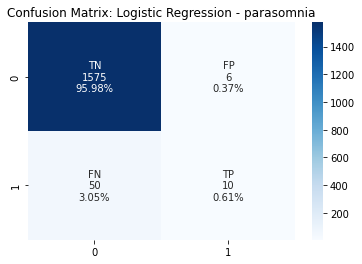

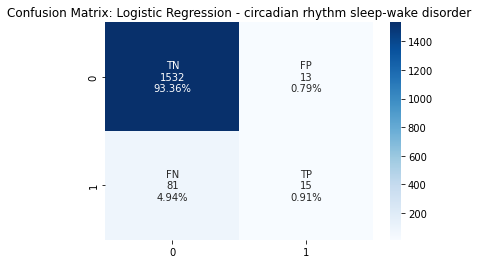

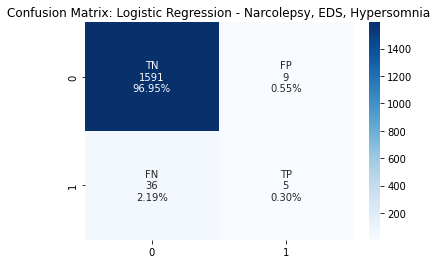

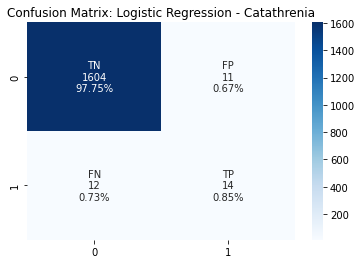

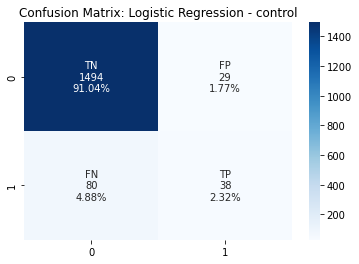

In [87]:
eval_metrics(y_test, title='Confusion Matrix: Logistic Regression', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

## ClassifierChain

In [88]:
logreg = LogisticRegression(C=0.01, max_iter=20000, random_state=42)

chain_logreg = ClassifierChain(logreg, order='random', random_state=42)
chain_logreg.fit(X_train, y_train)

ClassifierChain(base_estimator=LogisticRegression(C=0.01, max_iter=20000,
                                                  random_state=42),
                order='random', random_state=42)

In [89]:
y_pred = chain_logreg.predict(X_test)
y_pred_proba = chain_logreg.predict_proba(X_test)

OSA accuracy: 0.9171237050578915
insomnia accuracy: 0.903107861060329
PLMD, RLS accuracy: 0.9061547836684948
parasomnia accuracy: 0.9664838513101767
circadian rhythm sleep-wake disorder accuracy: 0.9439366240097502
Narcolepsy, EDS, Hypersomnia accuracy: 0.9725776965265083
Catathrenia accuracy: 0.9859841560024375
control accuracy: 0.9347958561852528
total accuracy: 0.6550883607556368
                                      precision    recall  f1-score   support

                                 OSA       0.94      0.94      0.94      1178
                            insomnia       0.47      0.22      0.30       155
                           PLMD, RLS       0.69      0.37      0.48       193
                          parasomnia       0.65      0.18      0.29        60
circadian rhythm sleep-wake disorder       0.58      0.16      0.25        96
        Narcolepsy, EDS, Hypersomnia       0.36      0.12      0.18        41
                         Catathrenia       0.56      0.54      0.55

/Users/hannahan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


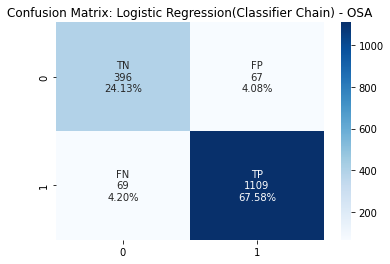

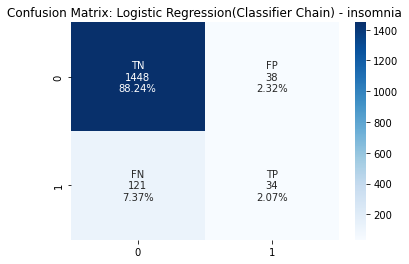

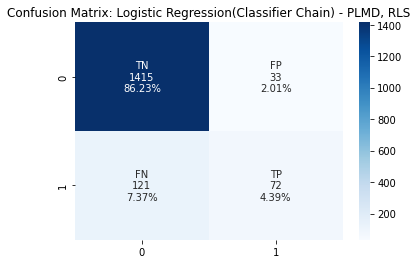

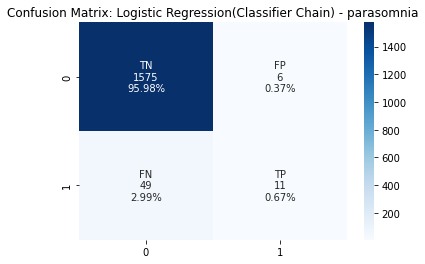

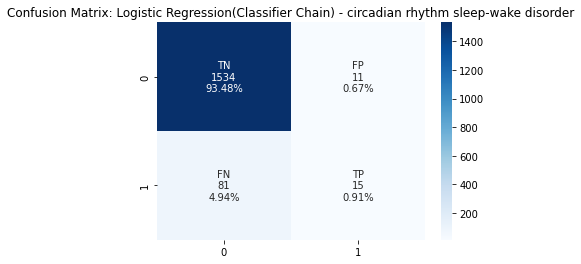

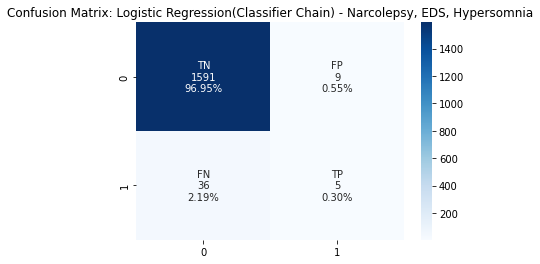

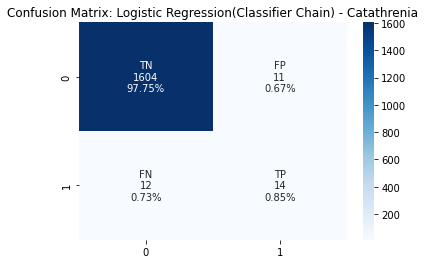

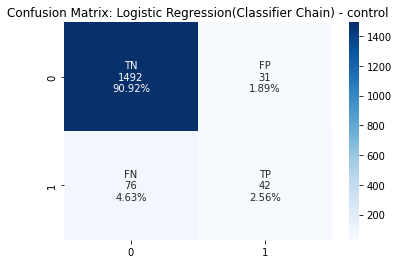

In [90]:
eval_metrics(y_test, title='Confusion Matrix: Logistic Regression(Classifier Chain)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)